## Import Libraries

In [36]:
import requests
import json
import pandas as pd
import numpy as np
import time
import random
import matplotlib.cm as cm
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
pd.set_option("display.max_rows", None)

## Set constant variables

In [4]:
base_url = 'https://csgostats.gg/'
leaderboards_url = 'https://csgostats.gg/leaderboards'

## Get list of ranks and the urls for each rank leaderboard.

### Using Requests (can't scrape due to captcha)

In [3]:
result = requests.get(leaderboards_url)
soup = BeautifulSoup(result.text, 'html.parser')
soup

<!DOCTYPE html>

<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Attention Required! | Cloudflare</title>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<meta content="noindex, nofollow" name="robots"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<link href="/cdn-cgi/styles/cf.errors.css" id="cf_styles-css" rel="stylesheet"/>
<!--[if lt IE 9]><link rel="stylesheet" id='cf_styles-ie-css' href="/cdn-cgi/styles/cf.errors.ie.css" /><![endif]-->
<style>body{margin:0;padding:0}</style>
<!--[if gte IE 10]><!-->
<script>
  if (!navigator.cookieEnabled) {
    window.addEventListener('DOMContentLoaded', function

### Using selenium (success)

In [8]:
username = 'chris'

# webdriver options
chromeOptions = Options()
# chromeOptions.add_argument('--kiosk')                          # sets the headless browser into full screen mode
# chromeOptions.add_argument('--headless')                       # opens the browser silently (hides it, if you enable this, make sure to disable kiosk)
chromeOptions.add_argument('--log-level=3')                    # stops the headless browser's logging features
# chromeOptions.add_argument('blink-settings=imagesEnabled=false') # set loading images to be false (for faster loading)
chromeOptions.add_argument('--no-sandbox')                     # required when running as root user. otherwise you would get no sandbox errors. 
chromeOptions.add_argument('--disable-extensions')
chromeOptions.add_argument('--disable-gpu')
chromeOptions.page_load_strategy = 'eager'

# to prevent getting a captcha, make it look like that the bot is a human
chromeOptions.add_argument("--profile-directory=Default")
chromeOptions.add_argument("--user-data-dir=C:/Users/%s/AppData/Local/Google/Chrome/User Data" % username)
chromeOptions.add_argument('--disable-blink-features=AutomationControlled')

chromeOptions.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36")

# Run the Driver
driver = webdriver.Chrome('./chromedriver/chromedriver.exe', options=chromeOptions, service_args=['--verbose'])

C:\Users\chris\AppData\Local\Temp\ipykernel_2248\2506721761.py:22: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver/chromedriver.exe', options=chromeOptions, service_args=['--verbose'])


In [ ]:
# Close the driver
driver.close()

In [95]:
# Get the list of ranks and the corresponding leaderboards in that rank
ranks = {
    'Rank': [],
    'URL': [],
}

# Go to Leaderboards page
driver.get(leaderboards_url)

# Loop the competitive rank images
for li in driver.find_elements_by_tag_name('ul')[5].find_elements_by_tag_name('li'):
    rank_name = li.find_element_by_tag_name('img').get_attribute('alt')
    rank_url = li.find_element_by_tag_name('a').get_attribute('href')
    
    print(rank_name, '|', rank_url)
    
    ranks['Rank'].append(rank_name)
    ranks['URL'].append(rank_url)

C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:6: DeprecationWarning: find_elements_by_tag_name is deprecated. Please use find_elements(by=By.TAG_NAME, value=name) instead
  for li in driver.find_elements_by_tag_name('ul')[5].find_elements_by_tag_name('li'):
C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:7: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  rank_name = li.find_element_by_tag_name('img').get_attribute('alt')
C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:8: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  rank_url = li.find_element_by_tag_name('a').get_attribute('href')


Silver I | https://csgostats.gg/leaderboards/1
Silver II | https://csgostats.gg/leaderboards/2
Silver III | https://csgostats.gg/leaderboards/3
Silver IV | https://csgostats.gg/leaderboards/4
Silver Elite | https://csgostats.gg/leaderboards/5
Silver Elite Master | https://csgostats.gg/leaderboards/6
Gold Nova I | https://csgostats.gg/leaderboards/7
Gold Nova II | https://csgostats.gg/leaderboards/8
Gold Nova III | https://csgostats.gg/leaderboards/9
Gold Nova Master | https://csgostats.gg/leaderboards/10
Master Guardian I | https://csgostats.gg/leaderboards/11
Master Guardian II | https://csgostats.gg/leaderboards/12
Master Guardian Elite | https://csgostats.gg/leaderboards/13
Distinguished Master Guardian | https://csgostats.gg/leaderboards/14
Legendary Eagle | https://csgostats.gg/leaderboards/15
Legendary Eagle Master | https://csgostats.gg/leaderboards/16
Supreme Master First Class | https://csgostats.gg/leaderboards/17
The Global Elite | https://csgostats.gg/leaderboards/18


In [96]:
ranks_df = pd.DataFrame(ranks)
ranks_df.head()

,Rank,URL
0,Silver I,https://csgostats.gg/leaderboards/1
1,Silver II,https://csgostats.gg/leaderboards/2
2,Silver III,https://csgostats.gg/leaderboards/3
3,Silver IV,https://csgostats.gg/leaderboards/4
4,Silver Elite,https://csgostats.gg/leaderboards/5


In [98]:
ranks_df.to_json('ranks.json', orient='records')

## Get all the players and their stats for each rank

### Scraping Timeframe: 
1. 06/16/22 5PM to 06/16/22 8PM. 
2. 06/17/2022 7:30AM to 06/17/2022 8:30AM.

In [3]:
ranks_df = pd.read_json('ranks.json')
ranks_df.head()

,Rank,URL
0,Silver I,https://csgostats.gg/leaderboards/1
1,Silver II,https://csgostats.gg/leaderboards/2
2,Silver III,https://csgostats.gg/leaderboards/3
3,Silver IV,https://csgostats.gg/leaderboards/4
4,Silver Elite,https://csgostats.gg/leaderboards/5


In [9]:
players_data = {
    'Competitive Rank': [],
    'Leaderboards Rank': [],
    'Username': [],
    'Primary Weapon': [],
    'Secondary Weapon': [],
    'K/D Score': [],
    'K/D Ratio': [],
    'HS %': [],
    'Win Rate': [],
    '1vX': [],
    'Rating': []
}

for _, data in list(ranks_df.iterrows())[14:]:
    page = 1
    print(data['Rank'])
    while(True):
        # Get the URL passing the page query
        driver.get(data['URL'] + ('?page=%d' % page))
        
        # Pass the html source of the result to beautiful soup
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        # Get all the players using class global-lb and recursive=False
        players = soup.find('div', class_='global-lb').find_all('div', recursive=False)[3].find_all('div', recursive=False)[:-1]
        print('Page %d: %d players' % (page, len(players)))
        
        if(len(players) == 0):
            break
        
        for div in players:
            # Get all top layer divs 
            # Note: there are no classes or ids that could select each players
            divs = div.find_all('div', recursive=False)
            if(len(divs) > 0): # if 
                rank = divs[0].text.strip().replace('#', '')
                username = divs[1].text.strip()
                primary = divs[2].find('img').get('title')
                secondary = divs[3].find('img').get('title')
                kd_score, kd_ratio = divs[4].text.strip().split('\n')
                hs_percent = divs[5].text.strip()
                win_rate = divs[6].text.strip()
                onevx = divs[7].text.strip()
                rating = divs[8].text.strip()

                players_data['Competitive Rank'].append(data['Rank'])
                players_data['Leaderboards Rank'].append(rank)
                players_data['Username'].append(username)
                players_data['Primary Weapon'].append(primary)
                players_data['Secondary Weapon'].append(secondary)
                players_data['K/D Score'].append(kd_score)
                players_data['K/D Ratio'].append(kd_ratio)
                players_data['HS %'].append(hs_percent)
                players_data['Win Rate'].append(win_rate)
                players_data['1vX'].append(onevx)
                players_data['Rating'].append(rating)

                # print('[', rank, ']', username, '|', primary, '|', secondary, '|', kd_score, '|', kd_ratio, '|', hs_percent, '|', win_rate, '|', onevx, '|', rating)
        
        page += 1
        
        # Add random delay to prevent excessive page request
        time.sleep(random.random() * 0.75 + 0.5)

Legendary Eagle
Page 1: 100 players
Page 2: 100 players
Page 3: 100 players
Page 4: 100 players
Page 5: 100 players
Page 6: 100 players
Page 7: 100 players
Page 8: 100 players
Page 9: 100 players
Page 10: 100 players
Page 11: 100 players
Page 12: 100 players
Page 13: 100 players
Page 14: 100 players
Page 15: 100 players
Page 16: 100 players
Page 17: 100 players
Page 18: 100 players
Page 19: 100 players
Page 20: 100 players
Page 21: 100 players
Page 22: 100 players
Page 23: 100 players
Page 24: 100 players
Page 25: 100 players
Page 26: 100 players
Page 27: 100 players
Page 28: 100 players
Page 29: 100 players
Page 30: 100 players
Page 31: 100 players
Page 32: 100 players
Page 33: 100 players
Page 34: 100 players
Page 35: 100 players
Page 36: 100 players
Page 37: 100 players
Page 38: 100 players
Page 39: 100 players
Page 40: 100 players
Page 41: 100 players
Page 42: 100 players
Page 43: 100 players
Page 44: 100 players
Page 45: 100 players
Page 46: 100 players
Page 47: 100 players
Page 4

Page 4: 100 players
Page 5: 100 players
Page 6: 100 players
Page 7: 100 players
Page 8: 100 players
Page 9: 100 players
Page 10: 100 players
Page 11: 100 players
Page 12: 100 players
Page 13: 100 players
Page 14: 100 players
Page 15: 100 players
Page 16: 100 players
Page 17: 100 players
Page 18: 100 players
Page 19: 100 players
Page 20: 100 players
Page 21: 100 players
Page 22: 100 players
Page 23: 100 players
Page 24: 100 players
Page 25: 100 players
Page 26: 100 players
Page 27: 100 players
Page 28: 100 players
Page 29: 100 players
Page 30: 100 players
Page 31: 100 players
Page 32: 100 players
Page 33: 100 players
Page 34: 100 players
Page 35: 100 players
Page 36: 100 players
Page 37: 100 players
Page 38: 100 players
Page 39: 100 players
Page 40: 100 players
Page 41: 100 players
Page 42: 100 players
Page 43: 100 players
Page 44: 100 players
Page 45: 100 players
Page 46: 100 players
Page 47: 100 players
Page 48: 100 players
Page 49: 100 players
Page 50: 100 players
Page 51: 100 player

Page 124: 100 players
Page 125: 100 players
Page 126: 100 players
Page 127: 100 players
Page 128: 100 players
Page 129: 100 players
Page 130: 100 players
Page 131: 100 players
Page 132: 100 players
Page 133: 100 players
Page 134: 100 players
Page 135: 100 players
Page 136: 100 players
Page 137: 100 players
Page 138: 100 players
Page 139: 100 players
Page 140: 100 players
Page 141: 100 players
Page 142: 100 players
Page 143: 100 players
Page 144: 100 players
Page 145: 100 players
Page 146: 100 players
Page 147: 100 players
Page 148: 100 players
Page 149: 100 players
Page 150: 100 players
Page 151: 100 players
Page 152: 100 players
Page 153: 100 players
Page 154: 100 players
Page 155: 100 players
Page 156: 100 players
Page 157: 100 players
Page 158: 100 players
Page 159: 100 players
Page 160: 100 players
Page 161: 100 players
Page 162: 100 players
Page 163: 100 players
Page 164: 100 players
Page 165: 100 players
Page 166: 100 players
Page 167: 100 players
Page 168: 100 players
Page 169: 

In [10]:
players_df = pd.DataFrame(players_data)
players_df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Legendary Eagle,1,千ㄥ乇乂,ssg08,mp9,5.54,388 / 70,56%,90%,6,4.17
1,Legendary Eagle,2,törkeä raiskaus,ssg08,usp_silencer,11.79,283 / 24,81%,90%,5,3.74
2,Legendary Eagle,3,WHY YOU NO WIN,ssg08,revolver,4.18,251 / 60,75%,80%,2,3
3,Legendary Eagle,4,☯,ak47,awp,6.37,312 / 49,28%,90%,18,2.98
4,Legendary Eagle,5,Heisenberg,ak47,m4a1_silencer,3.56,224 / 63,81%,80%,6,2.9


In [11]:
len(players_df)

96434

In [12]:
players_df.to_json('le-tge_players.json', orient='records', indent=4)

In [13]:
players_df = pd.read_json('le-tge_players.json')
players_df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Legendary Eagle,1,千ㄥ乇乂,ssg08,mp9,5.54,388 / 70,56%,90%,6,4.17
1,Legendary Eagle,2,törkeä raiskaus,ssg08,usp_silencer,11.79,283 / 24,81%,90%,5,3.74
2,Legendary Eagle,3,WHY YOU NO WIN,ssg08,revolver,4.18,251 / 60,75%,80%,2,3.00
3,Legendary Eagle,4,☯,ak47,awp,6.37,312 / 49,28%,90%,18,2.98
4,Legendary Eagle,5,Heisenberg,ak47,m4a1_silencer,3.56,224 / 63,81%,80%,6,2.90


## Combining all the files
From the scraping, we seperated the files since some failures occur, so we save the progress to a json file. Now we have to combine all the files so get all the players.

In [2]:
json_files = [
    'silver1_players.json',
    'silver2_players.json',
    'silver3_players.json',
    's4-mg2_players.json',
    'mg2_players.json',
    'mge-le_players.json',
    'le-tge_players.json'
]

dfs = []

for file in json_files:
    dfs.append(pd.read_json('./initial_data/' + file))
    
df = pd.concat(dfs, axis=0)
len(df)

NameError: name 'pd' is not defined

### Remove duplicate values
To get the duplicated values, we create a new column named `Unique` which contains the `Competitive Rank` and `Leaderboards Rank`. This works since `Leaderboards Rank` should only occur once in each `Competitive Rank`

In [86]:
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97


In [87]:
# Create a "Unique" column
df['Unique'] = df.apply(lambda x: x['Competitive Rank'] + ' ' + str(x['Leaderboards Rank']), axis=1)
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating,Unique
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75,Silver I 1
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10,Silver I 2
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99,Silver I 3
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98,Silver I 4
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97,Silver I 5


As can be seen, the original values were 517738, and when we get the unique values it became 481792. This shows that there are duplicated values.

In [88]:
print(len(df), len(df['Unique'].unique()))

517738 481792


Remove Duplicates

In [89]:
df = df.drop_duplicates(['Unique'])
len(df)

481792

In [90]:
# Remove column
del df['Unique']
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97


In [91]:
# Save df to json
df.to_json('./data/players.json', orient='records', indent=4)

## Data Preprocessing

In [92]:
df = pd.read_json('./data/players.json')
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97


### Convert `HS %` into Integer

In [93]:
df['HS %'] = df['HS %'].apply(lambda x: x.replace('%', '')).astype(int)

### Convert `Win Rate` into Integer

In [94]:
df['Win Rate'] = df['Win Rate'].apply(lambda x: x.replace('%', '')).astype(int)

### Create column for `Kills`

In [95]:
df['Kills'] = df['K/D Ratio'].apply(lambda x: x.split(' / ')[0]).astype(int)

### Create column for `Deaths`

In [96]:
df['Deaths'] = df['K/D Ratio'].apply(lambda x: x.split(' / ')[1]).astype(int)

### Remove `K/D Ratio` column

In [97]:
del df['K/D Ratio']
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,33,90,12,2.75,195,29
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,65,80,11,2.10,277,129
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,59,10,2,1.99,227,96
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,52,50,11,1.98,228,132
4,Silver I,5,The Honse,ak47,revolver,1.92,52,60,7,1.97,265,138


### Replace Nulls and blank values with "None"

In [101]:
df.fillna("None", inplace = True)
df.isnull().sum()
df.loc[df['Primary Weapon'].eq(""),'Primary Weapon'] = 'None'
df.loc[df['Secondary Weapon'].eq(""),'Secondary Weapon'] = 'None'

### Merge Knife weapons into One knife category

In CSGO, The knives are a singular weapon with no performance difference no matter what the skin is so all knife entries would be changed to "knife"

In [23]:
df['Primary Weapon'].value_counts()

ak47                 319315
awp                   68482
m4a1_silencer         57470
p90                    6694
m4a1                   3365
deagle                 3078
sg556                  2977
aug                    2959
ssg08                  2931
mp7                    2601
negev                  1836
galilar                1677
bizon                  1350
xm1014                 1270
mp9                    1107
mac10                  1028
mp5sd                   785
famas                   403
ump45                   357
revolver                317
None                    285
usp_silencer            250
mag7                    245
nova                    201
scar20                  138
glock                   131
p250                     93
elite                    80
tec9                     79
g3sg1                    67
sawedoff                 64
hkp2000                  31
fiveseven                27
taser                    23
m4a1_silencer_off        23
cz75a               

In [24]:
df['Secondary Weapon'].value_counts()

m4a1_silencer        148840
ak47                 106127
awp                   91885
m4a1                  57402
deagle                18617
p90                    6650
aug                    5710
mp9                    5468
ssg08                  5349
sg556                  4649
galilar                3852
mac10                  3642
mp7                    3501
usp_silencer           3401
famas                  2929
glock                  1911
negev                  1831
xm1014                 1580
bizon                  1482
mp5sd                  1148
ump45                   885
p250                    816
mag7                    659
revolver                587
tec9                    458
scar20                  337
elite                   327
nova                    310
None                    308
hkp2000                 287
fiveseven               227
g3sg1                   162
m4a1_silencer_off       125
sawedoff                 99
taser                    84
cz75a               

In [102]:
#Locates an entry within the dataframe under column 'Primary Weapon' that matches the regex and changes entry to 'knife'
df.loc[df['Primary Weapon'].str.contains(r'(?i)knife'),'Primary Weapon'] = 'knife'
df['Primary Weapon'].value_counts()

ak47                 319315
awp                   68482
m4a1_silencer         57470
p90                    6694
m4a1                   3365
deagle                 3078
sg556                  2977
aug                    2959
ssg08                  2931
mp7                    2601
negev                  1836
galilar                1677
bizon                  1350
xm1014                 1270
mp9                    1107
mac10                  1028
mp5sd                   785
famas                   403
ump45                   357
revolver                317
None                    285
usp_silencer            250
mag7                    245
nova                    201
scar20                  138
glock                   131
p250                     93
elite                    80
tec9                     79
g3sg1                    67
sawedoff                 64
hkp2000                  31
fiveseven                27
taser                    23
m4a1_silencer_off        23
cz75a               

It can be seen from the value_counts() function that multiple knife weapons instances are in both the primary weapon and secondary weapon columns so those knife weapon instances would all be renamed to just "knife"

In [103]:
#Locates an entry within the dataframe under column 'Primary Weapon' that matches the regex and changes the entry to 'knife'
df.loc[df['Secondary Weapon'].str.contains(r'(?i)knife'),'Secondary Weapon'] = 'knife'
df.loc[df['Secondary Weapon'].str.contains(r'(?i)bayonet'),'Secondary Weapon'] = 'knife'
df['Secondary Weapon'].value_counts()

m4a1_silencer        148840
ak47                 106127
awp                   91885
m4a1                  57402
deagle                18617
p90                    6650
aug                    5710
mp9                    5468
ssg08                  5349
sg556                  4649
galilar                3852
mac10                  3642
mp7                    3501
usp_silencer           3401
famas                  2929
glock                  1911
negev                  1831
xm1014                 1580
bizon                  1482
mp5sd                  1148
ump45                   885
p250                    816
mag7                    659
revolver                587
tec9                    458
scar20                  337
elite                   327
nova                    310
None                    308
hkp2000                 287
fiveseven               227
g3sg1                   162
m4a1_silencer_off       125
sawedoff                 99
taser                    84
cz75a               

In [104]:
# Save df to json
df.to_json('./data/players.json', orient='records', indent=4)

## Exploratory Data Analysis

In [14]:
df = pd.read_json('./data/players.json')
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,33,90,12,2.75,195,29
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,65,80,11,2.10,277,129
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,59,10,2,1.99,227,96
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,52,50,11,1.98,228,132
4,Silver I,5,The Honse,ak47,revolver,1.92,52,60,7,1.97,265,138


In [15]:
df.describe()

,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
count,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000
mean,18757.933714,1.013394,38.183341,45.649035,4.572322,1.000669,165.000745,165.769135
std,13614.756154,0.310852,9.064786,17.407108,2.805125,0.244459,46.199131,32.142983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7507.000000,0.830000,32.000000,30.000000,3.000000,0.840000,135.000000,152.000000
50%,15952.000000,0.980000,38.000000,50.000000,4.000000,0.980000,166.000000,173.000000
75%,27955.000000,1.160000,44.000000,60.000000,6.000000,1.140000,195.000000,188.000000
max,54675.000000,28.330000,93.000000,100.000000,30.000000,4.990000,485.000000,254.000000


## Answering Questions:

### What is the average K/D, 1vx, and Rating per Competitive Rank?

In [16]:
df.groupby('Competitive Rank')[['K/D Score', 'Kills', 'Deaths', 'HS %', 'Win Rate', '1vX', 'Rating']].mean().sort_values('Rating', ascending=False)

,K/D Score,Kills,Deaths,HS %,Win Rate,1vX,Rating
Competitive Rank,,,,,,,
The Global Elite,1.315104,188.839515,152.014617,43.197474,63.917669,4.960624,1.213471
Supreme Master First Class,1.114175,175.611949,161.881324,41.909220,50.661509,4.591103,1.082548
Legendary Eagle Master,1.075519,183.289817,174.191299,41.017555,47.976131,4.880500,1.047462
Legendary Eagle,1.046198,167.368527,163.075935,40.642701,47.036110,4.434419,1.031125
Distinguished Master Guardian,1.040527,165.621098,162.099465,40.047162,46.286640,4.451570,1.026465
Master Guardian Elite,1.032603,163.247085,161.059581,39.240026,45.836257,4.424295,1.019631
Master Guardian II,1.021895,160.963344,160.251935,38.582745,44.915694,4.431751,1.011502
Master Guardian I,1.009787,158.059694,159.298767,38.131141,44.805229,4.389580,1.000773
Gold Nova Master,1.000760,176.386700,178.773775,37.150702,45.717955,5.004573,0.990907


### What is the most used primary and secondary weapon?

In [17]:
df['Primary Weapon'].value_counts()

ak47                 319315
awp                   68482
m4a1_silencer         57470
p90                    6694
m4a1                   3365
deagle                 3078
sg556                  2977
aug                    2959
ssg08                  2931
mp7                    2601
negev                  1836
galilar                1677
bizon                  1350
xm1014                 1270
mp9                    1107
mac10                  1028
mp5sd                   785
famas                   403
ump45                   357
revolver                317
None                    285
usp_silencer            250
mag7                    245
nova                    201
scar20                  138
glock                   131
p250                     93
elite                    80
tec9                     79
g3sg1                    67
sawedoff                 64
hkp2000                  31
fiveseven                27
taser                    23
m4a1_silencer_off        23
cz75a               

In [18]:
df['Secondary Weapon'].value_counts()

m4a1_silencer        148840
ak47                 106127
awp                   91885
m4a1                  57402
deagle                18617
p90                    6650
aug                    5710
mp9                    5468
ssg08                  5349
sg556                  4649
galilar                3852
mac10                  3642
mp7                    3501
usp_silencer           3401
famas                  2929
glock                  1911
negev                  1831
xm1014                 1580
bizon                  1482
mp5sd                  1148
ump45                   885
p250                    816
mag7                    659
revolver                587
tec9                    458
scar20                  337
elite                   327
nova                    310
None                    308
hkp2000                 287
fiveseven               227
g3sg1                   162
m4a1_silencer_off       125
sawedoff                 99
taser                    84
cz75a               

In [19]:
df[['Primary Weapon', 'Secondary Weapon']].value_counts()

Primary Weapon     Secondary Weapon 
ak47               m4a1_silencer        137653
                   awp                   81013
                   m4a1                  55588
m4a1_silencer      ak47                  46483
awp                ak47                  46411
ak47               deagle                14917
awp                m4a1_silencer          7691
m4a1_silencer      awp                    5154
ak47               mp9                    4047
                   p90                    3246
                   aug                    3067
awp                deagle                 3005
m4a1               ak47                   2567
ak47               ssg08                  2442
                   famas                  2397
awp                ssg08                  2319
p90                ak47                   2155
ak47               mac10                  2153
                   usp_silencer           1946
                   mp7                    1797
                   gali

### What is the distribution of players in each rank?

In [20]:
df['Competitive Rank'].value_counts()

Master Guardian I                53858
Master Guardian II               52843
Master Guardian Elite            47599
Distinguished Master Guardian    44146
Legendary Eagle                  37137
Gold Nova Master                 31924
Gold Nova III                    26658
Gold Nova II                     26193
Legendary Eagle Master           25975
Gold Nova I                      23459
Supreme Master First Class       23265
Silver Elite Master              20122
Silver Elite                     16992
Silver III                       14468
Silver IV                        12799
Silver II                        12436
The Global Elite                 10057
Silver I                          1861
Name: Competitive Rank, dtype: int64

<AxesSubplot:>

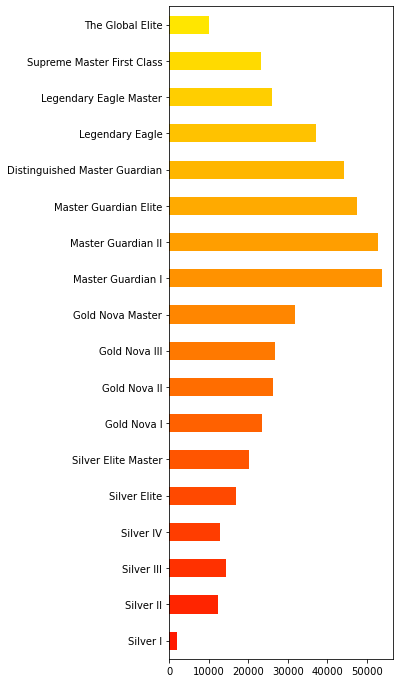

In [42]:
#Get the color map for the colors of autumn
cmap = cm.get_cmap('autumn')
#assigns the colors from the color map to an individual rank
colors = cmap(np.linspace(0.1, 0.9, df['Competitive Rank'].nunique()))
#Aggregate the players per rank and display as a horizontal bar graph
playerDistr =df['Competitive Rank'].value_counts(sort = False)
playerDistr.plot.barh(color=colors, figsize = (4,12))